# Load

In [1]:
import io
import logging
import math
import sys
import pandas as pd
from typing import Tuple, get_args
from py_ballisticcalc import Ammo, Atmo, Weapon, Shot, Calculator, HitResult
from py_ballisticcalc import ZeroFindingError, RangeError, TrajFlag, BaseEngineConfigDict, SciPyEngineConfigDict
from py_ballisticcalc import TableG7, logger, loadMetricUnits
from py_ballisticcalc.drag_model import DragModel
from py_ballisticcalc.helpers import must_fire, find_index_for_time_point
from py_ballisticcalc.unit import *
from py_ballisticcalc.interface import _EngineLoader
logger.setLevel(logging.WARNING)
print("\nAvailable engines: " + str(sorted([e.name for e in _EngineLoader.iter_engines()])))
loadMetricUnits()
PreferredUnits.drop = Distance.Meter
PreferredUnits.distance = Distance.Meter


Available engines: ['cythonized_euler_engine', 'cythonized_rk4_engine', 'euler_engine', 'rk4_engine', 'scipy_engine', 'verlet_engine']


## Reference Calculator

This _reference calculator_ will determine the "correct" trajectory against which the error of all others will be measured.


In [2]:
ref_config = SciPyEngineConfigDict(
    relative_tolerance=1e-12,
    absolute_tolerance=1e-12,
    integration_method="LSODA",
)
ref_calc = Calculator(ref_config, engine='scipy_engine')

# Scenarios

## 2km flat-fire trajectory

A typical 7.62mm bullet launched at an elevation (60mils, about 3.375 degrees) sufficient to reach approximately 2km.

We will use the reference calculator to compute the trajectory and then take the ZERO_DOWN (return-to-zero) row as our reference point for assessing the error in other engines.

,time,distance,velocity,mach,height,angle,density_factor,drag,energy,flag
1,0.001 s,0.7 m,800 m/s,2.35 mach,-0.0 m,3.3744 °,2.173e-05,0.691,3196 J,ZERO_UP
10,1.564 s,814.0 m,340 m/s,1.00 mach,38.8 m,1.5851 °,-3.693e-03,0.401,579 J,MACH
13,2.440 s,1086.3 m,292 m/s,0.86 mach,42.7 m,-0.0000 °,-4.071e-03,0.120,426 J,APEX
22,5.534 s,1861.7 m,219 m/s,0.64 mach,0.0 m,-6.9538 °,2.173e-05,0.081,240 J,ZERO_DOWN


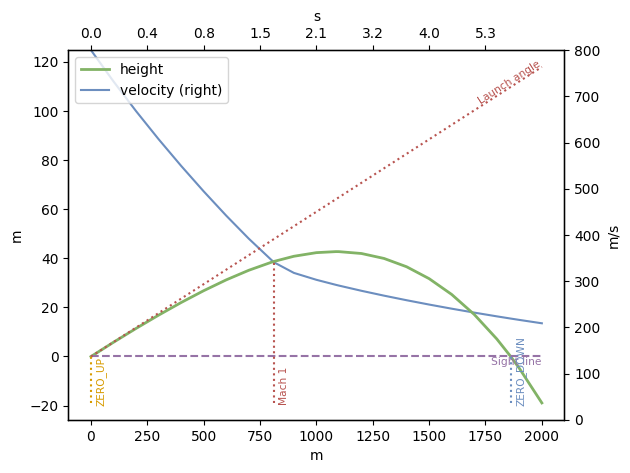

In [3]:
dm = DragModel(0.22, TableG7, Weight.Gram(10), Distance.Centimeter(7.62), Distance.Centimeter(3.0))
ammo = Ammo(dm, Velocity.MPS(800))
weapon = Weapon(sight_height=Distance.Centimeter(4), twist=Distance.Centimeter(30), zero_elevation=Angular.Mil(60.0))
baseline_shot = Shot(weapon=weapon, ammo=ammo, atmo=Atmo.icao())
range = Distance.Meter(2000)
range_step = Distance.Meter(100)
reference_trajectory = ref_calc.fire(shot=baseline_shot, trajectory_range=range, trajectory_step=range_step, extra_data=True)
reference_trajectory.plot()
ref = reference_trajectory.dataframe(True).drop(columns=['slant_height', 'drop_adj', 'windage', 'windage_adj', 'slant_distance', 'ogw'])
ref[ref.flag != "RANGE"]

### Define error

In [4]:
reference_row = reference_trajectory.flag(TrajFlag.ZERO_DOWN)
reference_distance = reference_row.distance
reference_distance_meter = reference_distance >> Distance.Meter
def check_error(hit: HitResult, output: bool = False) -> float:
    chkpt = hit.get_at_distance(reference_distance)
    if chkpt is not None:
        chk_x = chkpt.distance >> Distance.Meter
        chk_h = chkpt.height >> Distance.Meter
        chk_err = math.sqrt((chk_x-reference_distance_meter)**2 + chk_h**2)
        if output:
            print(f'At {chkpt.time}s: ({chk_x}, {chk_h})ft ==> Error = {chk_err:.8f}ft')
        return chk_err
    return float('inf')

summary = []

## SciPy

In [5]:
def scipy_chk(timeit: bool = False, **kwargs):
    config = SciPyEngineConfigDict(
        **kwargs,
    )
    calc = Calculator(config, engine='scipy_engine')
    hit, e = must_fire(calc, shot=baseline_shot, trajectory_range=range, trajectory_step=reference_distance)
    err = check_error(hit)
    evals = calc.integration_step_count
    if timeit:
        speed = %timeit -o must_fire(calc, shot=baseline_shot, trajectory_range=range, trajectory_step=reference_distance)
        return err, evals, speed.average
    return err, evals
logger.setLevel(logging.WARNING)
# Run with default tolerance:
err, count, speed = scipy_chk(timeit=True, integration_method="LSODA")
print(f'Error={err:.8f}ft.  Integration steps: {count}.  Speed: {speed:.5f}s')

71.4 ms ± 14.8 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Error=0.00016476ft.  Integration steps: 1776.  Speed: 0.07136s


### Integration Methods

Here's a quick look at each of the integration methods listed in the SciPyIntegrationEngine, using its default error tolerance settings.

In [6]:
from py_ballisticcalc.engines.scipy_engine import INTEGRATION_METHOD
method_summary = []
for method in get_args(INTEGRATION_METHOD):
    err, count, speed = scipy_chk(timeit=True, integration_method=method)
    method_summary.append(('SciPy', method, err, count, speed))
pd.DataFrame(method_summary, columns=['Engine', 'Setting', 'Error (ft)', 'Integration Steps', 'Speed']).set_index('Setting').sort_values(by='Error (ft)', ascending=True)

64.2 ms ± 4.46 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
30.5 ms ± 523 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)
134 ms ± 8.24 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
320 ms ± 34.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
210 ms ± 7.43 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
78.6 ms ± 8.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


,Engine,Error (ft),Integration Steps,Speed
Setting,,,,
Radau,SciPy,0.000003,4591,0.320331
BDF,SciPy,0.000036,1965,0.210161
RK23,SciPy,0.000076,1583,0.064177
LSODA,SciPy,0.000165,1776,0.078608
DOP853,SciPy,0.000852,5402,0.133773
RK45,SciPy,0.001351,1118,0.030461


### Tolerance

SciPy allows us to specify both "absolute" and "relative" error tolerance.  The meaning of the two terms and their interaction isn't always intuitive, so let's see what happens as we vary each while holding out the other term.  We'll do this for both the LSODA and RK45 methods.

#### LSODA

In [7]:
tol_tests = []
method = 'LSODA'
# Run with rtol as limiting factor
rtol = 1e-1
atol = 1e-13
while rtol > 1e-10:
    rtol /= 10.0
    err, count = scipy_chk(integration_method=method, relative_tolerance=rtol, absolute_tolerance=atol)
    tol_tests.append((method, atol, rtol, err, count))
# Run with atol as limiting factor
atol = 1e-1
rtol = 1e-13
while atol > 1e-10:
    atol /= 10.0
    err, count = scipy_chk(integration_method=method, relative_tolerance=rtol, absolute_tolerance=atol)
    tol_tests.append((method, atol, rtol, err, count))
pd.DataFrame(tol_tests, columns=['Method', 'Absolute Tolerance', 'Relative Tolerance', 'Error (m)', 'Integration Steps']).sort_values(by='Error (m)', ascending=False)

,Method,Absolute Tolerance,Relative Tolerance,Error (m),Integration Steps
0,LSODA,1.000000e-13,1.000000e-02,7.883671e-01,121
2,LSODA,1.000000e-13,1.000000e-04,2.085850e-02,162
10,LSODA,1.000000e-02,1.000000e-13,5.391509e-03,171
4,LSODA,1.000000e-13,1.000000e-06,2.277015e-03,496
11,LSODA,1.000000e-03,1.000000e-13,2.076198e-03,458
3,LSODA,1.000000e-13,1.000000e-05,1.303124e-03,263
1,LSODA,1.000000e-13,1.000000e-03,8.785060e-04,155
5,LSODA,1.000000e-13,1.000000e-07,7.917352e-04,1041
12,LSODA,1.000000e-04,1.000000e-13,1.915066e-04,1013
6,LSODA,1.000000e-13,1.000000e-08,9.840609e-05,1787


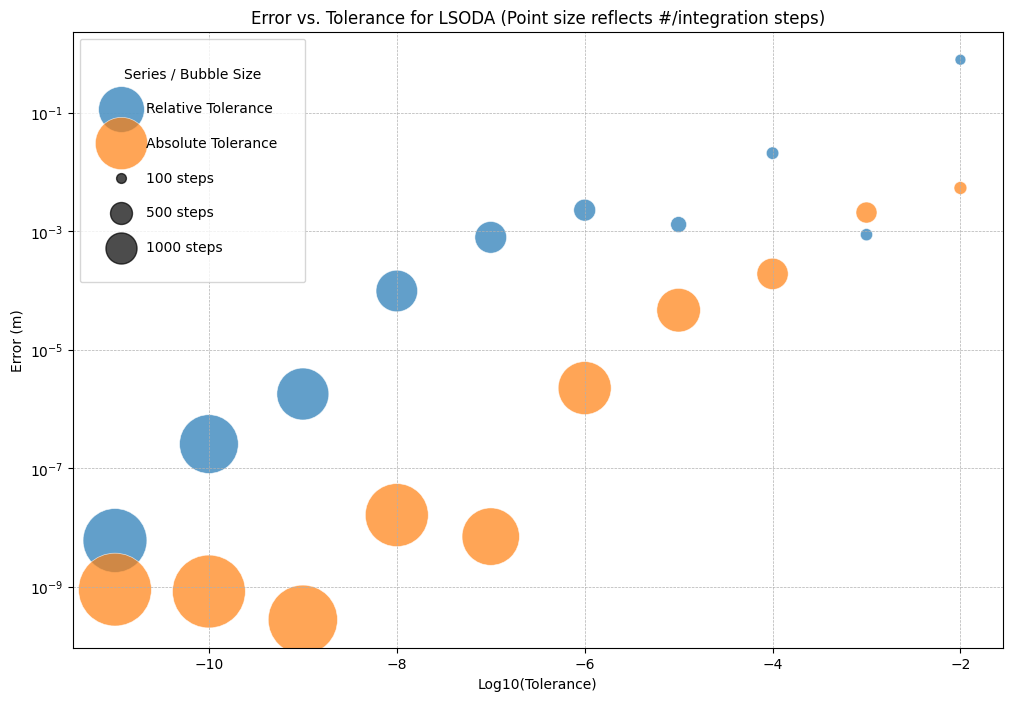

In [8]:
import matplotlib.pyplot as plt
import numpy as np
df_tol = pd.DataFrame(tol_tests, columns=['Method', 'Absolute Tolerance', 'Relative Tolerance', 'Error (m)', 'Integration Steps'])
# Separate the two series of data
atol_fixed = df_tol[df_tol['Absolute Tolerance'] == 1e-13].copy()
rtol_fixed = df_tol[df_tol['Relative Tolerance'] == 1e-13].copy()

fig, ax = plt.subplots(figsize=(12, 8))
# Plot the series where Absolute Tolerance is fixed
ax.scatter(
    np.log10(atol_fixed['Relative Tolerance']),
    atol_fixed['Error (m)'],
    s=atol_fixed['Integration Steps'] * 0.5,  # Scale size for better visibility
    label='Relative Tolerance',
    alpha=0.7,
    edgecolors='w',
    linewidth=0.5
)
# Plot the series where Relative Tolerance is fixed
ax.scatter(
    np.log10(rtol_fixed['Absolute Tolerance']),
    rtol_fixed['Error (m)'],
    s=rtol_fixed['Integration Steps'] * 0.5,  # Scale size for better visibility
    label='Absolute Tolerance',
    alpha=0.7,
    edgecolors='w',
    linewidth=0.5
)
ax.set_xlabel('Log10(Tolerance)')
ax.set_ylabel('Error (m)')
ax.set_title('Error vs. Tolerance for LSODA (Point size reflects #/integration steps)')
ax.legend()
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.set_yscale('log') # Use a log scale for error to see the full range
# Add a legend for bubble sizes
for steps in [100, 500, 1000]:
    ax.scatter([], [], s=steps * 0.5, c='k', alpha=0.7, label=f'{steps} steps')
ax.legend(title='Series / Bubble Size', scatterpoints=1, labelspacing=1.5, borderpad=2)
plt.show()

#### RK45

In [9]:
method = 'RK45'
# Run with rtol as limiting factor
rtol = 1e-1
atol = 1e-13
while rtol > 1e-10:
    rtol /= 10.0
    try:
        err, count = scipy_chk(integration_method=method, relative_tolerance=rtol, absolute_tolerance=atol)
        tol_tests.append((method, atol, rtol, err, count))
    except ArithmeticError as e:
        print(f"Failed to reach distance with {rtol=}")
        continue
# Run with atol as limiting factor
atol = 1e-1
rtol = 1e-13
while atol > 1e-10:
    atol /= 10.0
    try:
        err, count = scipy_chk(integration_method=method, relative_tolerance=rtol, absolute_tolerance=atol)
        tol_tests.append((method, atol, rtol, err, count))
    except ArithmeticError as e:
        print(f"Failed to reach distance with {atol=}")
        continue
df_tol = pd.DataFrame(tol_tests, columns=['Method', 'Absolute Tolerance', 'Relative Tolerance', 'Error (m)', 'Integration Steps']).sort_values(by='Error (m)', ascending=False)
df_tol[df_tol['Method'] == 'RK45']

,Method,Absolute Tolerance,Relative Tolerance,Error (m),Integration Steps
20,RK45,1.000000e-13,1.000000e-02,4.809026e+00,110
21,RK45,1.000000e-13,1.000000e-03,1.423357e+00,116
22,RK45,1.000000e-13,1.000000e-04,1.383468e-01,134
23,RK45,1.000000e-13,1.000000e-05,5.931756e-02,170
31,RK45,1.000000e-03,1.000000e-13,2.401295e-02,176
30,RK45,1.000000e-02,1.000000e-13,2.320769e-02,110
24,RK45,1.000000e-13,1.000000e-06,1.041117e-02,218
25,RK45,1.000000e-13,1.000000e-07,9.707970e-03,428
32,RK45,1.000000e-04,1.000000e-13,3.350603e-03,512
26,RK45,1.000000e-13,1.000000e-08,7.707628e-04,1364


#### Chart

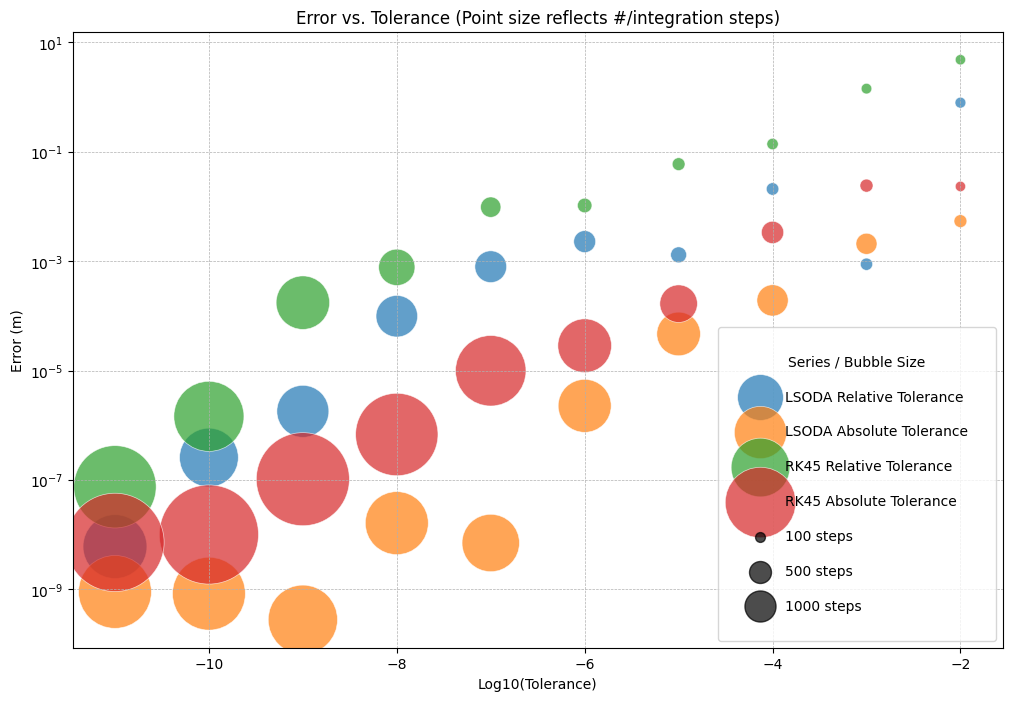

In [10]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(12, 8))
for method in ['LSODA', 'RK45']:
    atol_fixed = df_tol[(df_tol.Method == method) & (df_tol['Absolute Tolerance'] == 1e-13)].copy()
    rtol_fixed = df_tol[(df_tol.Method == method) & (df_tol['Relative Tolerance'] == 1e-13)].copy()
    # Plot the series where Absolute Tolerance is fixed
    ax.scatter(
        np.log10(atol_fixed['Relative Tolerance']),
        atol_fixed['Error (m)'],
        s=atol_fixed['Integration Steps'] * 0.5,  # Scale size for better visibility
        label=method + ' Relative Tolerance',
        alpha=0.7,
        edgecolors='w',
        linewidth=0.5
    )
    # Plot the series where Relative Tolerance is fixed
    ax.scatter(
        np.log10(rtol_fixed['Absolute Tolerance']),
        rtol_fixed['Error (m)'],
        s=rtol_fixed['Integration Steps'] * 0.5,  # Scale size for better visibility
        label=method + ' Absolute Tolerance',
        alpha=0.7,
        edgecolors='w',
        linewidth=0.5
    )
ax.set_xlabel('Log10(Tolerance)')
ax.set_ylabel('Error (m)')
ax.set_title('Error vs. Tolerance (Point size reflects #/integration steps)')
ax.legend()
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.set_yscale('log') # Use a log scale for error to see the full range
# Add a legend for bubble sizes
for steps in [100, 500, 1000]:
    ax.scatter([], [], s=steps * 0.5, c='k', alpha=0.7, label=f'{steps} steps')
ax.legend(title='Series / Bubble Size', scatterpoints=1, labelspacing=1.5, borderpad=2)
plt.show()

### Chosen

For purposes of charting against the non-SciPy methods, we'll vary these two SciPy methods over a range of tolerance settings that give monotonically increasing error with speed.

In [11]:
method = 'RK45'
atol = 1e-10
while atol < 0.1:
    err, count, speed = scipy_chk(timeit=True, integration_method=method, absolute_tolerance=atol, relative_tolerance=1e-12)
    summary.append(('SciPy '+method, atol, err, count, speed))
    atol *= 10.0
df = pd.DataFrame(summary, columns=['Engine', 'atol', 'Error (m)', 'Integration Steps', 'Speed'])
df[df.Engine == 'SciPy '+method]

279 ms ± 23.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
222 ms ± 37 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
190 ms ± 8 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
147 ms ± 1.24 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
93 ms ± 11.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
40.9 ms ± 1.88 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
15.6 ms ± 1.67 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
6.28 ms ± 372 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
4.69 ms ± 344 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


,Engine,atol,Error (m),Integration Steps,Speed
0,SciPy RK45,1.000000e-10,1.510798e-08,8702,0.278965
1,SciPy RK45,1.000000e-09,1.255155e-07,7520,0.222203
2,SciPy RK45,1.000000e-08,2.763066e-07,6722,0.189956
3,SciPy RK45,1.000000e-07,2.057640e-06,5156,0.146818
4,SciPy RK45,1.000000e-06,1.278431e-04,3080,0.093024
5,SciPy RK45,1.000000e-05,1.206575e-04,1448,0.040924
6,SciPy RK45,1.000000e-04,3.347521e-03,512,0.015596
7,SciPy RK45,1.000000e-03,2.401246e-02,176,0.006280
8,SciPy RK45,1.000000e-02,2.320759e-02,110,0.004689


In [12]:
method = 'LSODA'
rtol = 1e-10
while rtol < 0.1:
    err, count, speed = scipy_chk(timeit=True, integration_method=method, relative_tolerance=rtol, absolute_tolerance=1e-12)
    summary.append(('SciPy '+method, rtol, err, count, speed))
    rtol *= 10.0
df = pd.DataFrame(summary, columns=['Engine', 'rtol', 'Error (m)', 'Integration Steps', 'Speed'])
df[df.Engine == 'SciPy '+method]

152 ms ± 17.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
111 ms ± 1.72 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
70.2 ms ± 1.34 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
40.6 ms ± 2.36 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
18.4 ms ± 983 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
11 ms ± 368 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
7.64 ms ± 424 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
7.55 ms ± 935 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
5.52 ms ± 314 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


,Engine,rtol,Error (m),Integration Steps,Speed
9,SciPy LSODA,1.000000e-10,5.352754e-08,3490,0.151671
10,SciPy LSODA,1.000000e-09,1.469043e-06,2887,0.110726
11,SciPy LSODA,1.000000e-08,8.541609e-05,1802,0.070160
12,SciPy LSODA,1.000000e-07,8.163509e-04,1010,0.040575
13,SciPy LSODA,1.000000e-06,5.839277e-04,444,0.018361
14,SciPy LSODA,1.000000e-05,1.059694e-02,269,0.011048
15,SciPy LSODA,1.000000e-04,2.085870e-02,160,0.007640
16,SciPy LSODA,1.000000e-03,1.797862e-02,151,0.007548
17,SciPy LSODA,1.000000e-02,2.064240e-02,107,0.005515


## Other engines

In [13]:
def chk_engine(engine_name: str, timeit: bool = False, step_multiplier: float = 1.0):
    config = BaseEngineConfigDict(
        cStepMultiplier=step_multiplier,
    )
    calc = Calculator(config, engine=engine_name)
    hit, e = must_fire(calc, shot=baseline_shot, trajectory_range=range, trajectory_step=reference_distance)
    err = check_error(hit, False)
    evals = calc.integration_step_count
    if timeit:
        speed = %timeit -o must_fire(calc, shot=baseline_shot, trajectory_range=range, trajectory_step=reference_distance)
        return err, evals, speed.average
    return err, evals

## RK4

In [14]:
step = 5.0
multiplier = 1.0/step**2
while multiplier <= 1000.0:
    err, count, speed = chk_engine('rk4_engine', timeit=True, step_multiplier=multiplier)
    summary.append(('RK4', multiplier, err, count, speed))
    multiplier *= step
df = pd.DataFrame(summary, columns=['Engine', 'Multiplier', 'Error (m)', 'Integration Steps', 'Speed'])
df[df.Engine == 'RK4']

7.66 s ± 264 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.43 s ± 79.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
280 ms ± 7.25 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
56.7 ms ± 2.15 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
11.7 ms ± 552 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
3.29 ms ± 1.04 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
698 μs ± 34.8 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


,Engine,Multiplier,Error (m),Integration Steps,Speed
18,RK4,0.04,0.000213,231899,7.658366
19,RK4,0.20,0.000951,46380,1.433660
20,RK4,1.00,0.005174,9276,0.279717
21,RK4,5.00,0.017582,1856,0.056737
22,RK4,25.00,0.128988,372,0.011723
23,RK4,125.00,0.429837,75,0.003288
24,RK4,625.00,2.782793,15,0.000698


## Verlet

In [15]:
step = 5.0
multiplier = 1.0/step**2
while multiplier <= 500.0:
    err, count, speed = chk_engine('verlet_engine', timeit=True, step_multiplier=multiplier)
    summary.append(('Verlet', multiplier, err, count, speed))
    multiplier *= step
df = pd.DataFrame(summary, columns=['Engine', 'Multiplier', 'Error (m)', 'Integration Steps', 'Speed'])
df[df.Engine == 'Verlet']

4.69 s ± 154 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
984 ms ± 145 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
203 ms ± 9.41 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
37.2 ms ± 1.74 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
7.9 ms ± 562 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.68 ms ± 56.4 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


,Engine,Multiplier,Error (m),Integration Steps,Speed
25,Verlet,0.04,0.005741,347846,4.689517
26,Verlet,0.20,0.028685,69568,0.983639
27,Verlet,1.00,0.143862,13912,0.202565
28,Verlet,5.00,0.720899,2781,0.037157
29,Verlet,25.00,3.698342,555,0.007898
30,Verlet,125.00,21.619532,109,0.001683


## Euler

In [16]:
step = 5.0
multiplier = 1.0/step**2
while multiplier <= 1000.0:
    err, count, speed = chk_engine('euler_engine', timeit=True, step_multiplier=multiplier)
    summary.append(('Euler', multiplier, err, count, speed))
    multiplier *= step
df = pd.DataFrame(summary, columns=['Engine', 'Multiplier', 'Error (m)', 'Integration Steps', 'Speed'])
df[df.Engine == 'Euler']

5.33 s ± 222 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.1 s ± 151 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
204 ms ± 7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
41.5 ms ± 2.06 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
8.17 ms ± 99.6 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.84 ms ± 91.7 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
504 μs ± 7.88 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


,Engine,Multiplier,Error (m),Integration Steps,Speed
31,Euler,0.04,0.002065,545834,5.332033
32,Euler,0.20,0.010319,109166,1.095095
33,Euler,1.00,0.051491,21833,0.204205
34,Euler,5.00,0.258586,4366,0.041519
35,Euler,25.00,1.296182,873,0.008173
36,Euler,125.00,6.662502,174,0.001842
37,Euler,625.00,37.926920,34,0.000504


## Euler constant step

Here we monkey-patch the `EulerIntegrationEngine` to use a constant time step to see if that has any effect on performance.

In [17]:
from py_ballisticcalc.engines.euler import EulerIntegrationEngine
def time_step(self, base_step: float, velocity: float) -> float:
    return base_step
EulerIntegrationEngine.time_step = time_step
step = 0.0001
while step <= 1.0:
    err, count, speed = chk_engine('euler_engine', step_multiplier=step, timeit=True)
    summary.append(('Euler const', step, err, count, speed))
    step *= 5.0
df = pd.DataFrame(summary, columns=['Engine', 'Step Size', 'Error (m)', 'Integration Steps', 'Speed'])
df[df.Engine == 'Euler const']

2.82 s ± 296 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
534 ms ± 12.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
102 ms ± 3.03 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
27 ms ± 9.93 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
4.41 ms ± 290 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.08 ms ± 71.3 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


,Engine,Step Size,Error (m),Integration Steps,Speed
38,Euler const,0.0001,0.007188,278277,2.820315
39,Euler const,0.0005,0.035994,55654,0.534430
40,Euler const,0.0025,0.179954,11130,0.102437
41,Euler const,0.0125,0.905893,2225,0.027034
42,Euler const,0.0625,4.595404,444,0.004410
43,Euler const,0.3125,24.964721,88,0.001076


## RK4 Compiled

TODO

# Summary

The following chart shows that the highly adaptive SciPy solvers are in a class of their own: They produce the smallest errors, and can do so with an order of magnitude less compute.  Certainly part of this is thanks to their compiled core.

The poor showing by the velocity Verlet engine is striking but not unexpected: It is a second-order integrator, but one of its notable design advantages is conservation of energy. However, a ballistic trajectory with air resistance is a _dissipative_ system: The drag force varies with velocity, and this breaks the time-reversibility that the Verlet formulas were designed to exploit.  The result, as we see here, is that the Verlet's performance is reduced to that of the simpler, first-order Euler method.

## Chart

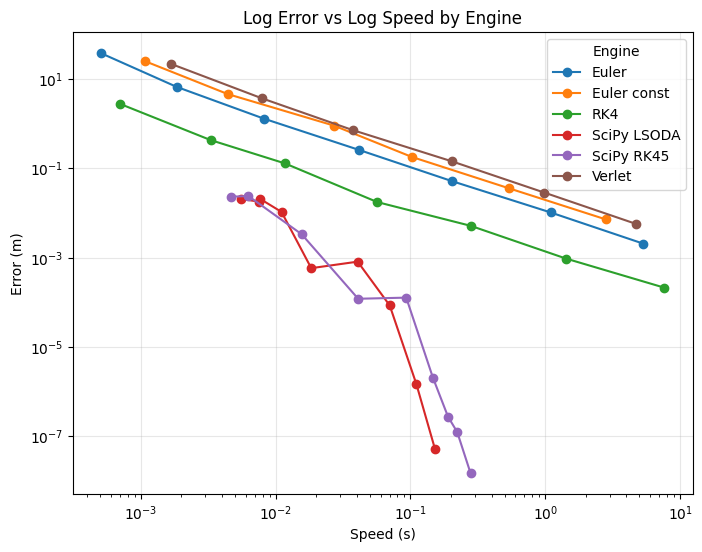

In [18]:
from matplotlib import pyplot as plt
dfplot = pd.DataFrame(summary, columns=['Engine', 'Step Size (s)', 'Error (m)', 'Integration Steps', 'Speed'])
fig, ax = plt.subplots(figsize=(8, 6))
for engine, group in dfplot.groupby('Engine'):
    ax.plot(group['Speed'], group['Error (m)'], marker='o', label=engine)
ax.set_xlabel('Speed (s)')
ax.set_ylabel('Error (m)')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('Log Error vs Log Speed by Engine')
ax.legend(title='Engine')
ax.grid(True, which='major', alpha=0.3)
plt.show()

## Data

In [19]:
display(dfplot.style.format({'Error (ft)': '{:.12f}'}))

,Engine,Step Size (s),Error (m),Integration Steps,Speed
0,SciPy RK45,0.000000,0.000000,8702,0.278965
1,SciPy RK45,0.000000,0.000000,7520,0.222203
2,SciPy RK45,0.000000,0.000000,6722,0.189956
3,SciPy RK45,0.000000,0.000002,5156,0.146818
4,SciPy RK45,0.000001,0.000128,3080,0.093024
5,SciPy RK45,0.000010,0.000121,1448,0.040924
6,SciPy RK45,0.000100,0.003348,512,0.015596
7,SciPy RK45,0.001000,0.024012,176,0.006280
8,SciPy RK45,0.010000,0.023208,110,0.004689
9,SciPy LSODA,0.000000,0.000000,3490,0.151671
